In [1]:
import pandas as pd
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import functools
import operator

In [68]:
def normalize_list(nested_list): # estandariza la lista
    regular_list = []
    for ele in nested_list:
        if type(ele) is list:
            regular_list.append(ele)
        else:
            regular_list.append([ele])
    return regular_list

# Variables globales

Se define la ubicacion donde esta el archivo json con las credenciales del servicio NLU de IBM, el path local donde se encuentran los datos raw a analizar (Cada dataset se identifica con el timestamp del sistema en que se ejecuto el programa main.py.) y el path local donde dejar el dataset con los resultados del análisis. Las credenciales de IBM se descargan en la página del servicio y se guardan en un fichero credentials.json con la estructura:

{
  "APIkey": "XXXX",
  "URL": "XXXXX"
}


Un script se encarga de extraerlas y cargarlas. 

In [2]:
from src.secrets.authentication import get_authentication

In [35]:
CREDENTIALS_FILE = '../config/credentials/credentials.json'
RAW_DATA_PATH = '../data/reviews/raw/1668080225'
PROC_DATA_PATH = '../data/reviews/proc/'

# Carga del cliente de IBM

In [4]:
URL, API_KEY = get_authentication(CREDENTIALS_FILE)
service = NaturalLanguageUnderstandingV1(authenticator=IAMAuthenticator(API_KEY),  version='2018-03-16')
service.set_service_url(URL)

# 1. Carga de un dataset

No se espera un gran volumen de datos en estos análisis, por lo que se usa pandas para procesar la información.

In [5]:
reviews_data = pd.read_csv(RAW_DATA_PATH)

## 1.1 Preprocesado

Se observan valores perdidos en el contenido. El usuario solo ha introducido un titulo y puntuación. Se rellena el contenido con el string del titulo para homogeneizar el campo content.

In [6]:
reviews_data.isnull().sum()

title          0
content        9
date           0
variant      312
images      1909
verified       0
author         0
rating         0
product        0
url         2053
dtype: int64

In [7]:
reviews_data.loc[reviews_data.content.isnull(), 'content'] = reviews_data.loc[reviews_data.content.isnull(), 'title']

# 2. Analisis del texto mediante el servicio Natural Language Understanding de IBM

En esta sección se llama al servicio mediante API. El código de la función está aparte por limpieza en el notebook.

In [8]:
from src.IBMNLU.APICalls import sentiment_and_keyword

Me diante la función se hace análisis ad-hoc de las respuestas. En este notebook, de la respuesta en formato json, solo se utiliza el label del sentimiento y las palabras clave. 

In [45]:
sentiment = []
keywords = []

for index, review in enumerate(reviews_data.content[:200]): # solo 200 resultados
    try:
        
        response = sentiment_and_keyword(review, service)
        
        reviews_data.loc[index, 'sentiment_label'] = response['sentiment']['document']['label']
        
        sentiment.append([index]+list(response['sentiment']['document'].values()))
        
        kw = []
        for keyword in response['keywords']:
            kw.append(list(keyword.values())[0])
            
        keywords.append(kw)
        
    except:
        pass

# 3. EDA de los resultados propuestos por Watson

En esta sección se analiza:

1. La proporción de criticas negativas y positivas (independientemente del rating del producto)
2. Un top de palabras clave (keywords) para ver de qué hablan los usuarios.


Para calcular el top de palabras se usa una visualización word cloud. Primero se transforma la lista de listas de palabras clave en una unica lista y se genera un unico string para la visualización. Despues se construye la visualización mediante la herramienta wordcloud.

In [52]:
reviews_data['keywords'] = pd.Series(keywords)

In [67]:
bag_of_words = functools.reduce(operator.iconcat, normalize_list(keywords), []) # lista de keywords.

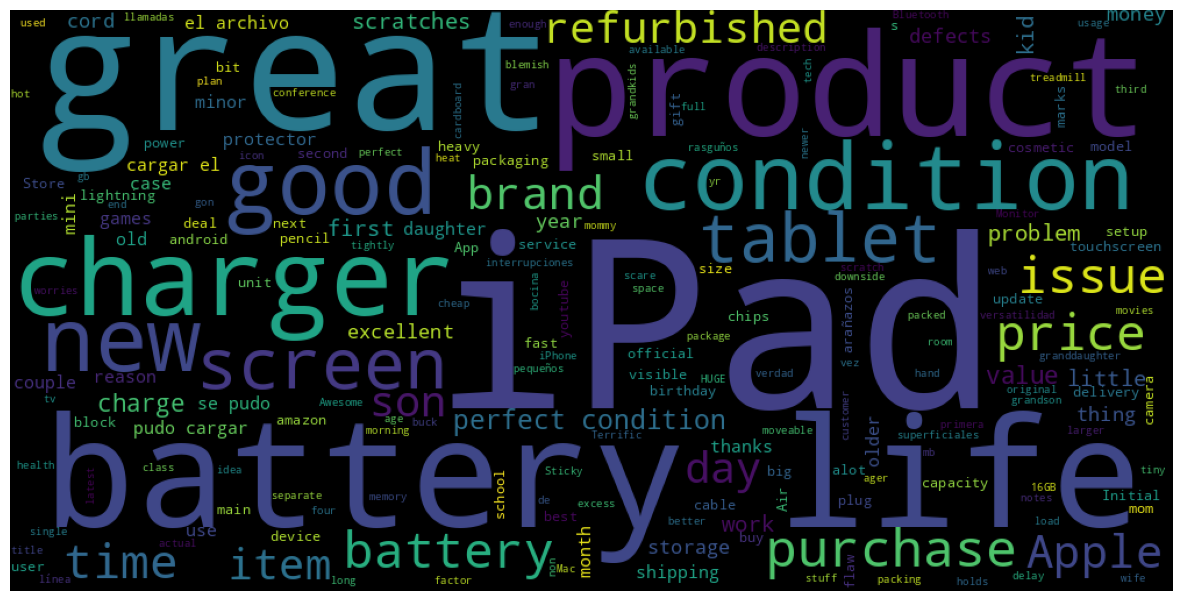

In [64]:
unique_string=(" ").join(bag_of_words)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

Se ve que las palabras más utilizadas en son Ipad (el propio producto), se hace referencia al cargador (charger) y a la vida de la batería (battery life). Si se está buscando ese producto es recomendable prestar atención a:

1. Temas relacionados con el cargador
2. Temas relacionaos con la batería

Se ve que hay palabras en español mexcladas con inglés, debe afinarse el servicio mediante detección de lenguage y traducción. 

Por último se calcula la proporción de críticas.

In [65]:
reviews_data.sentiment_label.value_counts(normalize=True)

positive    0.732984
negative    0.225131
neutral     0.041885
Name: sentiment_label, dtype: float64

Se ve que más del 70% de críticas es positiva para el producto seleccionado.

# 4. Se guarda el análisis

In [66]:
reviews_data.to_csv(PROC_DATA_PATH+'1668080225_proc', index=False)